In [2]:
%matplotlib inline
import json
import re
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from iexfinance import get_historical_data

DAY = datetime.timedelta(days = 1)

In [9]:
# Read our mined Tweets into a list
# 2.7M Tweets from 1/1/2016 to 5/31/2017 for Apple, or 1.2M from 1/1/2016 to 8/1/2018 for Tesla
tweets = []

for i in range(1, 6):
    file_name = "apple_tweets_2016_" + str(i) + ".json"
    with open(file_name, "r") as read_file:
        tweets += json.load(read_file)

In [64]:
# common name of the company we are analyzing
NAME = "Apple"
# TIMEFRAME over which the Tweets were mined
TIMEFRAME = [datetime.datetime(2016, 1, 1), datetime.datetime(2017, 5, 31)]
# specify the number of input features used in our machine learning model
NUM_FEATURES = 5
# the increment of days before the current day available to the predictive model
INC = datetime.timedelta(days = 1)

record = processTweets(TIMEFRAME, NUM_FEATURES, ticker = 'TSLA')
exportRecord(record, 'tsla_model_5_record')

In [12]:
# Process Tweets into a Numpy array with Numpy array entries representing data points
# each trading day is associated with a data point, consisting of these input features and a label:
# <today's # +tweets, today's # -tweets, yesterday's # +tweets, yesterday's # -tweets, 
# yesterday's price ROC : today's price ROC>


# Sets thresholds of sentiment polarity above which Tweets are considered positive and below
# which Tweets are considered negative; other Tweets are ignored as neutral/factual 
POSITIVE_THRESHOLD = 0.3
NEGATIVE_THRESHOLD = -0.3

def processTweets(timeframe, num_features, ticker):
    stock_data = get_historical_data(ticker, timeframe[0], timeframe[1], output_format='json')
    
    record = generateRecord(stock_data, num_features, ticker)
    
    # analyze sentiment of Tweets
    for n in range(0, len(tweets)):
        tweet = TextBlob(tweets[n]['text'])
        date = toDatetime(tweets[n]['timestamp'][0:10])
        
        if date not in record: 
            continue # we only analyze Tweets posted on trading days

        current_sentiment = sentiment(tweet, ticker)
        if current_sentiment >= POSITIVE_THRESHOLD:
            record[date][0] += 1
        elif current_sentiment <= NEGATIVE_THRESHOLD:
            record[date][1] += 1
    
    # fill in "yesterday" data
    for today in record:
        tomorrow = today + DAY
        if tomorrow in record:
            record[tomorrow][2] = record[today][0]
            record[tomorrow][3] = record[today][1]
    
    record = addStockTrends(stock_data, record, ticker)
    
    record_list = np.array(list(record.values()))
    
    return record_list

In [11]:
# Returns the 'record': a dictionary which associates datetime objects with data points
def generateRecord(stock_data, num_features, ticker):
    datetime_list =[]
    for date_string in stock_data[ticker].keys():
        datetime_list.append(toDatetime(date_string))
    datetime_list.sort()
    
    datetime_list[:] = [date for date in datetime_list if date - INC in datetime_list]
    
    record = {}
    for date in datetime_list:
        record[date] = np.zeros(num_features + 1).astype('float32')
    
    return record

In [13]:
# converts a string of the form YYYY-MM-DD into the corresponding datetime object
def toDatetime(date_string):
    return datetime.datetime(int(date_string[0:4]), int(date_string[5:7]), int(date_string[8:10]))

In [14]:
# accepts a TextBlob, formats as a parsable tweet, and returns its polarity
cashtag_re = re.compile('\$\D')

def sentiment(tweet, ticker):
    if tweet.find('http') != -1:
        return 0
        
    tweet = tweet.replace('$'+ticker, NAME).replace('#'+ticker, NAME).replace('#'+NAME, NAME)
    
    if cashtag_re.search(str(tweet)) != None:
        return 0
    
    return tweet.polarity

In [15]:
# adds price rate of change (ROC) to the data points in the record
def addStockTrends(stock_data, record, ticker):
    for today in list(record.keys()):
        if  record[today][2] == 0 and record[today][3] == 0:
            del record[today]
        else:
            last_day = today - INC
            record[today][4] = ROC(stock_data, last_day, ticker)
            record[today][5] = ROC(stock_data, today, ticker)
    
    empty_dates = [date for date in record if record[date][0] == 0 and record[date][1] == 0]
    for date in empty_dates:
        record.pop(date, None)
    
    return record

In [16]:
# converts datetime object to string of form YYYY-MM-DD
def datetimeToString(date):
    s = [str(date.year), str(date.month), str(date.day)]
    return s[0] + '-' + ('0' + s[1] if int(s[1]) < 10 else s[1]) + '-' + ('0' + s[2] if int(s[2]) < 10 else s[2])

# returns the price rate of change of stock on the given datetime with n = 1 day
def ROC(stock_data, date, ticker):
    todays_close = stock_data[ticker][datetimeToString(date)]['close']
    yesterdays_close = stock_data[ticker][datetimeToString(date - DAY)]['close']
    return (todays_close - yesterdays_close) / yesterdays_close

In [17]:
# export our list with Numpy
def exportRecord(record, name):
    np.save('twitter_project/' + name + '.npy', record)

In [10]:
##########################
# MODEL ACCURACY REPORTS #
##########################

Mean Absolute Error of Apple – 1.7M Tweets: 0.01031231787831833
Mean Absolute Percentage Error: 1.3844043517352753


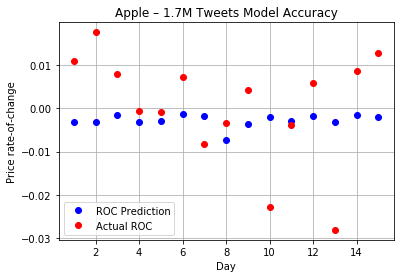

In [26]:
accuracyReport('Apple – 1.7M Tweets', 'RR_aapl_predictions', True)

Mean Absolute Error of Apple – 2.7M Tweets: 0.008420542965233415
Mean Absolute Percentage Error: 2.4548622667917326


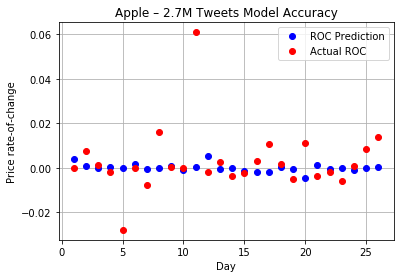

In [28]:
accuracyReport('Apple – 2.7M Tweets', 'aapl_model_2_predictions', True)

Mean Absolute Error of Apple – 2.7M Tweets CONTROL: 0.007941102975914523
Mean Absolute Percentage Error: 1.0919231832915046


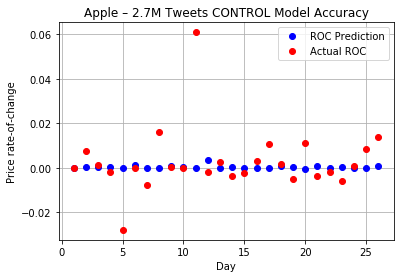

In [38]:
accuracyReport('Apple – 2.7M Tweets CONTROL', 'aapl_model_2_ctrl_predictions', True)

Mean Absolute Error of Tesla – 270k Tweets: 0.016194179342520605
Mean Absolute Percentage Error: 4.8531431955655275


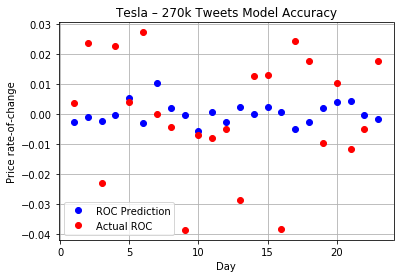

In [30]:
accuracyReport('Tesla – 270k Tweets', 'tsla_model_5_predictions', True)

Mean Absolute Error of Tesla – 560k Tweets: 0.02182189748689
Mean Absolute Percentage Error: 1.6868017857815754


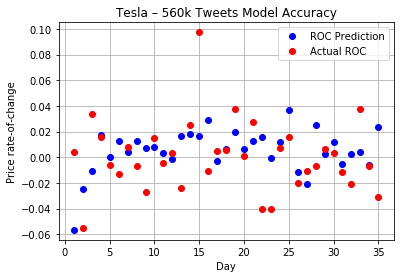

In [33]:
accuracyReport('Tesla – 560k Tweets', 'R_tesla', True)

Mean Absolute Error of Tesla – 1.2M Tweets: 0.020965200803994416
Mean Absolute Percentage Error: 1.207800191640557


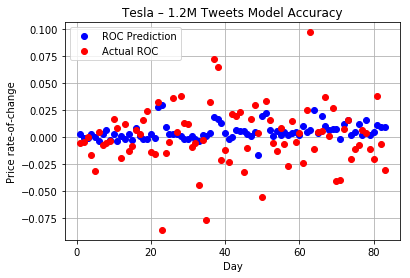

In [35]:
accuracyReport('Tesla – 1.2M Tweets', 'tsla_model_2_predictions', True)

Mean Absolute Error of Tesla – 1.2M Tweets CONTROL: 0.020679671783701527
Mean Absolute Percentage Error: 1.0072168368523189


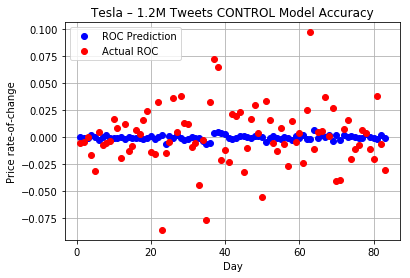

In [39]:
accuracyReport('Tesla – 1.2M Tweets CONTROL', 'tsla_model_2_ctrl_predictions', True)

In [20]:
def accuracyReport(name, file, save):
    model_predictions = np.load('twitter_project/' + file + '.npy')
    mae = MAE(model_predictions)
    mape = MAPE(model_predictions)
    
    print("Mean Absolute Error of " + name + f": {mae}")
    plotModelAccuracy(name, model_predictions)
    print(f"Mean Absolute Percentage Error: {mape}")
    
    if save:
        plt.savefig('twitter_project/' + name + '.png')

In [5]:
def plotModelAccuracy(name, model_predictions):
    estimates = model_predictions[:,0]
    actuals = model_predictions[:,1]
    days = range(1, len(estimates)+1)

    plt.plot(days, estimates, 'bo', label = "ROC Prediction")
    plt.plot(days, actuals, 'ro', label = "Actual ROC")
    plt.title(name + " Model Accuracy")
    plt.xlabel("Day")
    plt.ylabel("Price rate-of-change")
    plt.legend()
    plt.grid(True)

In [6]:
def MAE(model_predictions):
    residuals = 0
    for prediction in model_predictions:
        residuals += abs(prediction[0] - prediction[1])
    
    return residuals / len(model_predictions)

In [7]:
def MAPE(model_predictions):
    residuals = 0
    for prediction in model_predictions:
        if prediction[1] != 0:
            residuals += abs((prediction[1] - prediction[0]) / prediction[1])
    
    return residuals / len(model_predictions)